<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Pipeline Notebook #


**Author**: David Law (AURA Associate Astronomer, MIRI branch), Kirsten Larson (ESA/AURA Astronomer, MIRI branch)
<br>
**Last Updated**: April 23, 2024
<br>
**Pipeline Version**: 1.14.0

**Purpose**: This notebook provides a framework for processing generic MIRI MRS data through all three JWST pipeline stages.  Data is assumed to be located in two Observation folders (science and background) according to paths set up below.  It should not be necessary to edit any cells other than in the 'Configuration' section unless modifying the standard pipeline processing options.

**Data**: This example is set up to use observations of the LMC planetary nebula SMP LMC 058 obtained by PID 1523 Observation 3.  This is a point source that uses a standard 4-pt dither in all three grating settings.  It incorporates a dedicated background in Observation 4.  Example input data to use will be downloaded automatically unless disabled (i.e., to use local files instead).

**Updates**: 
This notebook is regularly updated as improvements are made to the pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/


**Recent Changes**:<br>
Sep 1 2022: Add some commentary and example on how to use multicore processing in Detector 1<br>
Sep 12 2022: Disable unnecessary cube/1d spectra production for individual science exposures in Spec 2<br>
Oct 14 2022: Include residual fringe correction in spec2 (note that this will CRASH earlier pipeline versions!<br>
Jun 29 2023: Update to latest 1.11.0 pipeline with photom, outlier detection, and x1d changes, add CRDS path options.  Change to SMP LMC 058 demo.<br>
Oct 11 2023: Update to 1.12.3 pipeline with 1d spectral residual fringe and auto-centroid options, 2d pixel replacement, and a variety of new cube build options.<br>
Nov 17 2023: Incorporate CRDS default parameters for detector1 and spec2<br>
Nov 20 2023: Significant revisions to allow use of associations in spec2, allow choice of pixel-based background subtraction.<br>
Nov 24 2023: Additional comments and plotting examples.<br>
Jan 31 2024: Update to 1.13.4 pipeline, enabling spectral leak correction<br>
Apr 12 2024: Migrate from MRS_FlightNB1 notebook, adapt to .call() format, add post-hook example, add demo mode capability.

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration <a class="anchor" id="intro"></a>
------------------

In [1]:
# Set parameters to be changed here.
# It should not be necessary to edit cells below this in general unless modifying pipeline processing steps.

import sys,os, pdb

# -----------------------------    Set CRDS context and paths   ----------------------------

# Set CRDS context (if overriding to use a specific version of reference files; leave commented out to use latest reference files by default)
#%env CRDS_CONTEXT  jwst_1146.pmap

# Set local CRDS directory if not set already in your .bashrc shell configuration
#os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')
# Set CRDS server directory if not set already in your .bashrc shell configuration
#os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
# Echo CRDS path in use
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

# -----------------------------    Demo Mode   ----------------------------

# If demo_mode = True, this notebook will download example data from MAST to process.
# This will all happen in a local directory unless modified in Section 4 below.
# Set this to False if you want to process your own data that has already been downloaded.

demo_mode = True
if demo_mode:
    print('Running in demonstration mode using online example data!')

# -----------------------------    User Mode Directories   ----------------------------

# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need to be changed to your
    # local directory setup (below are given as examples)
    user_home_dir = os.path.expanduser('~')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1, stage2, stage3 directories
    sci_dir = os.path.join(user_home_dir, 'FlightData/APT1523/data/Obs03/')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1, stage2, stage3 directories
    bg_dir = os.path.join(user_home_dir, 'FlightData/APT1523/data/Obs04/uncal/')
    #bg_dir = '' # If no background observation, use an empty string

# -----------------------------    Set Processing Steps   ----------------------------

# Whether or not to process only data from a given MRS band/channel (useful if overriding reference files)
# Note that BOTH must be set in order to work
use_ch = '' # '12' or '34'
use_band = '' # 'SHORT', 'MEDIUM', or 'LONG'

# Individual pipeline stages can be turned on/off here.  Note that a later stage won't be able to run unless data products
# have already been produced from the prior stage.

# Science processing
dodet1 = True # calwebb_detector1
dospec2 = True # calwebb_spec2
dospec3 = True # calwebb_spec3

# Background processing
dodet1bg = True # calwebb_detector1
dospec2bg = True # calwebb_spec2 (needed for Master Background subtraction)

# How should background subtraction using any dedicated backgrounds be done?
# If none are selected, cubes will not be background subtracted.  1d spectra will always use local annular background subtraction for point sources.
# Note that if using master-background subtraction, backgrounds must be select above to process through spec2
master_bg = True # Master-background subtraction in spec3 (subtract spectrum generated from the backgrounds).  This is the default pipeline setting.
pixel_bg = False # Pixel-based background subtraction in spec2 (direct pixel subtraction).

CRDS local filepath: /Users/dlaw/crds_cache/jwst_ops
CRDS file server: https://jwst-crds.stsci.edu
Running in demonstration mode using online example data!


<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Package Imports<a class="anchor" id="intro"></a>
------------------

In [2]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# Basic system utilities for interacting with files
#----------------------------------------------General Imports-----------------------------------------------------
import glob
import copy
import time
import shutil
import warnings
#import zipfile
#import urllib.request
# Numpy for doing calculations
import numpy as np

#--------------------------------------------Astropy Imports--------------------------------------------
# Astropy utilities for opening FITS and ASCII files, and downloading demo files
from astropy.io import fits
from astropy.io import ascii
#from astropy.utils.data import download_file
from astroquery.mast import Observations
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

#------------------------------------------------Plotting Imports--------------------------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [4]:
#--------------------------------------JWST Calibration Pipeline Imports-------------------------------------------
# Import the base JWST and calibration reference data packages
import jwst
import crds

# JWST pipelines (each encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

from stcal import dqflags # Utilities for working with the data quality (DQ) arrays
from jwst.stpipe import Step # Import the wrapper class for pipeline steps

# Echo pipeline version and CRDS context in use
print("JWST Calibration Pipeline Version={}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

2024-05-14 09:05:50,917 - stpipe - WARNING - /var/folders/lg/jw_brb093bl9n39fbgn1cw080001fw/T/ipykernel_4934/2534134647.py:17: DeprecationWarning: dqflags has been moved to stdatamodels.dqflags, please use that instead
2024-05-14 09:05:50,918 - stpipe - WARNING -   from stcal import dqflags # Utilities for working with the data quality (DQ) arrays
2024-05-14 09:05:50,920 - stpipe - WARNING - 


JWST Calibration Pipeline Version=0.13.0b1.dev3404+gfc2b670ac
Using CRDS Context = jwst_1230.pmap


In [5]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Demo Mode Setup (ignore if not using demo data)<a class="anchor" id="intro"></a>
------------------
<div class="alert alert-block alert-warning">
If running in demonstration mode, set up the base paths here, and retrieve the uncalibrated data from the MAST archive.  MAST allows for flexibility of searching by the proposal ID and the observation ID instead of just filenames.<br>
    
More information about the JWST file naming conventions can be found at: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html
</div>

In [6]:
# Set up the paths
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')
    program = "01523" 
    sci_observtn = "003"
    back_observtn = "004"
    visit = "001"
    basedir = "./mrs_demo_data/"
    download_dir = basedir
    sci_dir = basedir + 'Obs' + sci_observtn + '/'
    bg_dir = basedir + 'Obs' + back_observtn + '/'
    uncal_dir = os.path.join(sci_dir, 'uncal/')
    uncal_bgdir = os.path.join(bg_dir, 'uncal/')
    # Ensure filepaths for input data exist
    if not os.path.exists(uncal_dir):
        os.makedirs(uncal_dir)
    if not os.path.exists(uncal_bgdir):
        os.makedirs(uncal_bgdir)

Running in demonstration mode and will download example data from MAST!


In [7]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    # Science data
    sci_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IFU"],
                                           provenance_name=["CALJWST"], # Executed observations
                                           obs_id=['jw'+program+'-o'+sci_observtn+'*']
                                           ) 

    # Background data
    bg_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IFU"],
                                           provenance_name=["CALJWST"], # Executed observations
                                           obs_id=['jw'+program+'-o'+back_observtn+'*']
                                           )

In [8]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE','productSubGroupDescription': 'UNCAL','calib_level': [1]}}
    
    # Science files
    sci_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products,productType=query_dict['product_type'],
                                                         productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                         calib_level=query_dict['calib_level'])
            sci_files_to_download.extend(filtered_products['dataURI'])
            
    # Background files
    bg_files_to_download = []
    # Loop over visits identifying uncalibrated files that are associated with them
    for exposure in (bg_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products,productType=query_dict['product_type'],
                                                         productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                         calib_level=query_dict['calib_level'])
            bg_files_to_download.extend(filtered_products['dataURI'])
    
    # Cull to a unique list of files that contain 'mirifu' in the filename (i.e., not MIRI imager)
    sci_files_to_download = np.unique([i for i in sci_files_to_download if 'mirifu' in i])
    bg_files_to_download = np.unique([i for i in bg_files_to_download if 'mirifu' in i])
    
    print("Science files selected for downloading: ",len(sci_files_to_download))
    print("Background selected for downloading: ",len(bg_files_to_download))

Science files selected for downloading:  24
Background selected for downloading:  12


In [9]:
# Download all the uncal files and place them into the appropriate directories
# Warning: If this notebook is halted during this step the downloaded file may be incomplete, and cause crashes later on!
if demo_mode:
    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(filename, local_path=uncal_dir+filename.split('/')[-1])
    for filename in bg_files_to_download:
        bg_manifest = Observations.download_file(filename, local_path=uncal_bgdir+filename.split('/')[-1])

2024-05-14 09:05:58,254 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00001_mirifulong_uncal.fits with expected size 118938240.
2024-05-14 09:05:58,414 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00001_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:05:58,594 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00002_mirifulong_uncal.fits with expected size 118938240.
2024-05-14 09:05:58,787 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00002_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00002_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00002_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:05:58,976 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00003_mirifulong_uncal.fits with expected size 118938240.
2024-05-14 09:05:59,162 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00003_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:05:59,342 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits with expected size 118938240.
2024-05-14 09:05:59,524 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00004_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03102_00004_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:05:59,694 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00001_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00001_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:05:59,926 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:00,134 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00002_mirifulong_uncal.fits with expected size 118938240.
2024-05-14 09:06:00,305 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00002_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:00,461 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00003_mirifulong_uncal.fits with expected size 118938240.
2024-05-14 09:06:00,644 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00003_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00003_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00003_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:00,832 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00004_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00004_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:01,040 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:01,199 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00001_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00001_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:01,356 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00001_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:01,539 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00002_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00001_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00002_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:01,692 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00002_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:01,875 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00003_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00002_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00003_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:02,068 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:02,266 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00004_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00004_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:02,429 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:02,597 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00001_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs003/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00001_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:02,762 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00001_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:02,924 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00002_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00001_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00002_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:03,088 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00002_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:03,242 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00001_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02101_00002_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00001_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:03,403 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00001_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:03,580 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00002_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00001_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00002_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:03,762 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00002_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:03,944 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00001_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02103_00002_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00001_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:04,127 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00001_mirifushort_uncal.fits with expected size 118938240.
2024-05-14 09:06:04,292 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00002_mirifulong_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00001_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]
INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00002_mirifulong_uncal.fits with expected size 118938240. [astroquery.query]


2024-05-14 09:06:04,484 - stpipe - INFO - Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00002_mirifushort_uncal.fits with expected size 118938240.


INFO: Found cached file ./mrs_demo_data/Obs004/uncal/jw01523004001_02105_00002_mirifushort_uncal.fits with expected size 118938240. [astroquery.query]


<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Directory Setup<a class="anchor" id="intro"></a>
------------------
<div class="alert alert-block alert-warning">
Set up detailed paths to input/output stages here.</div>

In [10]:
# Define output subdirectories to keep science data products organized
uncal_dir = os.path.join(sci_dir, 'uncal/') # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1/') # calwebb_detector1 pipeline outputs will go here
spec2_dir = os.path.join(sci_dir, 'stage2/') # calwebb_spec2 pipeline outputs will go here
spec3_dir = os.path.join(sci_dir, 'stage3/') # calwebb_spec3 pipeline outputs will go here

# Output subdirectories to keep background data products organized
uncal_bgdir = os.path.join(bg_dir, 'uncal/') # Uncalibrated pipeline inputs should be here
det1_bgdir = os.path.join(bg_dir, 'stage1/') # calwebb_detector1 pipeline outputs will go here
spec2_bgdir = os.path.join(bg_dir, 'stage2/') # calwebb_spec2 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)
if (bg_dir != ''):
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)

In [11]:
# If there is no background folder, ensure we don't try to process it
if (bg_dir == ''):
    dodet1bg=False
    dospec2bg=False

In [12]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 13.2620 seconds


<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the calwebb_detector1 pipeline to create Stage 1 data products (i.e., uncalibrated slope images of the form *rate.fits).  These data products have units of DN/s.
    
See https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing/calwebb_detector1
</div>

In [13]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'], det1dict['saturation'], det1dict['ipc'] = {}, {}, {}, {}, {}
det1dict['firstframe'], det1dict['lastframe'], det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['charge_migration'], det1dict['jump'], det1dict['ramp_fit'] = {}, {}, {}, {}, {}
det1dict['gain_scale'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#det1dict['emicorr']['skip'] = True

# Overrides for various reference files
#det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits' # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits' # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits' # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits' # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits' # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits' # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits' # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits' # Read noise used by ramp fitting step

# Turn on multi-core processing (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'
det1dict['ramp_fit']['maximum_cores'] = 'half'

# This next parameter helps with very bright objects and/or very short ramps
det1dict['jump']['three_group_rejection_threshold'] = 100

# Turn on detection of cosmic ray showers (off by default)
det1dict['jump']['find_showers'] = True

In [14]:
# As an example of how to insert custom pipeline steps using the pre-hook/post-hook framework
# (see https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/tips-and-tricks-for-working-with-the-jwst-pipeline)
# we'll define a new step called XplyStep that multiplies everything by 1.0
# I.e., it does nothing, but could be changed to do something more interesting.
class XplyStep(Step):
 
     spec = '''
     '''
 
     class_alias = 'xply'
 
     def process(self, input_data):
        with datamodels.open(input_data) as model:
            result = model.copy()
        sci = result.data
        sci = sci * 1.0
        result.data = sci
        self.log.info('Multiplied everything by one in custom step!')
        return result
    
# And here we'll insert it into our pipeline dictionary to be run at the end right after the gain_scale step
det1dict['gain_scale']['post_hooks'] = [XplyStep]

In [15]:
# Look for input files of the form *uncal.fits from the science observation
sstring = uncal_dir + 'jw*mirifu*uncal.fits'
uncal_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '') & (use_band != '')):
    keep = np.zeros(len(uncal_files))
    for ii in range(0, len(uncal_files)):
        hdu = fits.open(uncal_files[ii])
        hdr = hdu[0].header
        if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
            keep[ii] = 1
        hdu.close()
    indx = np.where(keep == 1)
    uncal_files = uncal_files[indx]

print('Found ' + str(len(uncal_files)) + ' science input files')

Found 24 science input files


In [16]:
# Run the pipeline on these input files by a simple loop over files using our custom parameter dictionary
if dodet1:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_dir)
else:
    print('Skipping Detector1 processing for SCI data')

2024-05-14 09:06:04,959 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-emicorrstep_0002.asdf
2024-05-14 09:06:04,967 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-jumpstep_0003.asdf
2024-05-14 09:06:04,972 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0005.asdf
2024-05-14 09:06:05,026 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-05-14 09:06:05,026 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-05-14 09:06:05,027 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2024-05-14 09:06:05,027 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2024-05-14 09:06:05,028 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance cr

2024-05-14 09:06:05,159 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:06:05,160 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:06:05,161 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:06:05,161 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-05-14 09:06:05,161 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:06:35,255 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:06:35,264 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:06:35,444 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:06:35,484 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).
2024-05-14 09:06:35,492 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:06:35,552 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:06:35,591 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:06:59,051 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:06:59,052 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:06:59,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:06:59,089 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).
2024-05-14 09:06:59,102 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:06:59,103 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:06:59,141 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).
2024-05-14 09:06:59,153 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:06:59,640 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:06:59,642 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:06:59,642 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:06:59,642 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:06:59,642 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:07:31,402 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:07:31,409 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:07:31,626 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:07:31,666 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2024-05-14 09:07:31,674 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:07:31,760 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:07:31,799 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:07:54,402 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:07:54,402 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:07:54,403 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:07:54,441 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2024-05-14 09:07:54,453 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:07:54,453 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:07:54,490 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2024-05-14 09:07:54,500 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:07:54,912 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:07:54,914 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:07:54,914 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:07:54,914 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-05-14 09:07:54,914 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:08:25,978 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:08:25,986 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:08:26,152 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:08:26,193 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2024-05-14 09:08:26,202 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:08:26,249 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:08:26,287 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:08:50,867 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:08:50,868 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:08:50,868 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:08:50,908 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2024-05-14 09:08:50,922 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:08:50,922 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:08:50,962 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2024-05-14 09:08:50,973 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:08:51,398 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:08:51,400 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:08:51,400 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:08:51,400 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:08:51,400 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:09:23,223 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:09:23,231 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:09:23,407 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:09:23,450 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2024-05-14 09:09:23,459 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:09:23,509 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:09:23,549 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:09:45,850 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:09:45,850 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:09:45,851 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:09:45,892 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2024-05-14 09:09:45,905 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:09:45,906 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:09:45,954 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2024-05-14 09:09:45,966 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:09:46,398 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:09:46,400 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:09:46,400 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:09:46,401 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-05-14 09:09:46,401 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:10:18,010 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:10:18,023 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:10:18,201 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:10:18,243 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2024-05-14 09:10:18,251 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:10:18,299 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:10:18,338 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:10:41,768 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:10:41,769 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:10:41,769 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:10:41,809 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2024-05-14 09:10:41,823 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:10:41,823 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:10:41,863 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2024-05-14 09:10:41,873 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:10:42,300 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:10:42,302 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:10:42,302 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:10:42,302 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:10:42,303 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:11:14,787 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:11:14,801 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:11:14,999 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:11:15,061 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2024-05-14 09:11:15,072 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:11:15,129 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:11:15,178 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:11:38,841 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:11:38,842 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:11:38,843 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:11:38,892 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2024-05-14 09:11:38,906 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:11:38,906 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:11:38,948 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2024-05-14 09:11:38,958 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:11:39,392 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:11:39,393 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:11:39,394 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:11:39,394 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-05-14 09:11:39,394 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:12:11,553 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:12:11,567 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:12:11,751 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:12:11,802 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2024-05-14 09:12:11,810 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:12:11,862 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:12:11,911 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:12:35,484 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:12:35,484 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:12:35,485 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:12:35,530 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2024-05-14 09:12:35,544 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:12:35,544 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:12:35,586 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2024-05-14 09:12:35,597 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:12:36,044 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:12:36,046 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:12:36,046 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:12:36,046 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:12:36,047 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:13:08,146 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:13:08,162 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:13:08,344 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:13:08,391 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2024-05-14 09:13:08,399 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:13:08,448 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:13:08,495 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:13:30,967 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:13:30,967 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:13:30,968 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:13:31,014 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2024-05-14 09:13:31,027 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:13:31,027 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:13:31,074 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2024-05-14 09:13:31,086 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:13:31,552 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:13:31,554 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:13:31,555 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:13:31,555 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:13:31,555 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:14:03,734 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:14:03,749 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:14:03,930 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:14:03,981 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2024-05-14 09:14:03,990 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:14:04,041 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:14:04,088 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:14:27,415 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:14:27,415 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:14:27,416 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:14:27,461 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2024-05-14 09:14:27,474 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:14:27,474 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:14:27,521 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2024-05-14 09:14:27,532 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:14:27,972 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:14:27,974 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:14:27,974 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:14:27,975 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:14:27,975 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:15:00,296 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:15:00,305 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:15:00,477 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:15:00,524 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2024-05-14 09:15:00,533 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:15:00,585 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:15:00,631 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:15:24,330 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:15:24,330 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:15:24,331 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:15:24,377 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2024-05-14 09:15:24,391 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:15:24,391 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:15:24,439 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2024-05-14 09:15:24,450 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:15:24,894 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:15:24,896 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:15:24,897 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:15:24,897 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:15:24,897 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:15:56,738 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:15:56,753 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:15:56,918 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:15:56,965 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2024-05-14 09:15:56,974 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:15:57,022 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:15:57,069 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:16:20,535 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:16:20,535 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:16:20,536 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:16:20,582 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2024-05-14 09:16:20,595 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:16:20,595 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:16:20,641 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2024-05-14 09:16:20,651 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:16:21,108 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:16:21,110 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:16:21,110 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:16:21,111 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:16:21,111 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:16:53,575 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:16:53,591 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:16:53,774 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:16:53,823 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2024-05-14 09:16:53,832 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:16:53,882 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:16:53,926 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:17:16,579 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:17:16,579 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:17:16,580 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:17:16,627 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2024-05-14 09:17:16,640 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:17:16,640 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:17:16,683 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2024-05-14 09:17:16,693 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:17:17,126 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:17:17,128 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:17:17,128 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:17:17,129 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:17:17,129 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:17:49,313 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:17:49,324 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:17:49,500 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:17:49,545 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2024-05-14 09:17:49,554 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:17:49,604 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:17:49,649 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:18:12,936 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:18:12,937 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:18:12,938 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:18:12,983 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2024-05-14 09:18:12,997 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:18:12,997 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:18:13,044 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2024-05-14 09:18:13,054 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:18:13,503 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:18:13,505 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:18:13,505 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:18:13,506 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:18:13,506 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:18:45,656 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:18:45,671 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:18:45,868 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:18:45,914 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2024-05-14 09:18:45,923 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:18:45,971 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:18:46,014 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:19:08,501 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:19:08,502 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:19:08,503 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:19:08,546 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2024-05-14 09:19:08,559 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:19:08,559 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:19:08,602 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2024-05-14 09:19:08,612 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:19:09,060 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:19:09,062 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:19:09,062 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:19:09,062 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:19:09,062 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:19:40,996 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:19:41,006 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:19:41,208 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:19:41,255 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2024-05-14 09:19:41,264 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:19:41,312 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:19:41,356 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:20:04,924 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:20:04,924 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:20:04,925 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:20:04,967 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2024-05-14 09:20:04,980 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:20:04,981 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:20:05,025 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2024-05-14 09:20:05,035 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:20:05,477 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:20:05,478 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:20:05,479 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:20:05,479 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:20:05,479 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:20:37,497 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:20:37,506 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:20:37,695 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:20:37,740 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2024-05-14 09:20:37,749 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:20:37,798 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:20:37,840 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:20:59,873 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:20:59,874 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:20:59,874 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:20:59,917 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2024-05-14 09:20:59,930 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:20:59,930 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:20:59,975 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2024-05-14 09:20:59,985 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:21:00,431 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:21:00,433 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:21:00,433 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:21:00,433 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:21:00,434 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:21:32,601 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:21:32,617 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:21:32,809 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:21:32,854 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2024-05-14 09:21:32,863 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:21:32,912 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:21:32,957 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:21:56,341 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:21:56,342 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:21:56,342 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:21:56,385 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2024-05-14 09:21:56,398 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:21:56,398 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:21:56,441 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2024-05-14 09:21:56,452 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:21:56,903 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:21:56,905 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:21:56,905 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:21:56,905 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-05-14 09:21:56,906 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:22:29,501 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:22:29,517 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:22:29,719 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:22:29,765 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2024-05-14 09:22:29,774 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:22:29,827 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:22:29,871 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:22:54,012 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:22:54,013 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:22:54,013 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:22:54,056 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2024-05-14 09:22:54,071 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:22:54,071 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:22:54,116 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2024-05-14 09:22:54,127 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:22:54,586 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:22:54,587 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:22:54,588 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:22:54,588 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:22:54,588 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:23:26,447 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:23:26,463 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:23:26,657 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:23:26,706 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2024-05-14 09:23:26,715 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:23:26,764 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:23:26,811 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:23:49,909 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:23:49,909 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:23:49,910 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:23:49,954 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2024-05-14 09:23:49,968 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:23:49,968 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:23:50,011 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2024-05-14 09:23:50,021 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:23:50,464 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:23:50,465 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:23:50,466 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:23:50,466 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-05-14 09:23:50,466 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:24:22,539 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:24:22,555 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:24:22,750 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:24:22,796 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2024-05-14 09:24:22,806 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:24:22,859 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:24:22,905 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:24:44,744 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:24:44,745 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:24:44,745 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:24:44,792 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2024-05-14 09:24:44,806 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:24:44,807 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:24:44,855 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2024-05-14 09:24:44,866 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:24:45,315 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:24:45,316 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:24:45,317 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:24:45,317 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:24:45,317 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:25:17,113 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:25:17,132 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:25:17,319 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:25:17,365 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2024-05-14 09:25:17,374 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:25:17,422 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:25:17,467 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:25:41,005 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:25:41,006 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:25:41,006 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:25:41,052 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2024-05-14 09:25:41,066 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:25:41,066 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:25:41,114 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2024-05-14 09:25:41,125 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:25:41,565 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:25:41,567 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:25:41,568 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:25:41,568 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-05-14 09:25:41,568 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:26:14,052 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:26:14,061 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:26:14,258 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:26:14,304 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2024-05-14 09:26:14,314 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:26:14,363 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:26:14,407 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:26:36,440 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:26:36,441 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:26:36,441 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:26:36,490 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2024-05-14 09:26:36,504 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:26:36,504 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:26:36,551 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2024-05-14 09:26:36,561 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:26:37,007 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:26:37,009 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:26:37,009 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:26:37,009 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:26:37,010 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:27:09,069 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:27:09,090 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:27:09,295 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:27:09,340 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2024-05-14 09:27:09,349 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:27:09,400 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:27:09,442 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-05-14 09:27:32,637 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:27:32,638 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:27:32,638 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:27:32,683 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2024-05-14 09:27:32,696 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:27:32,696 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:27:32,740 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2024-05-14 09:27:32,750 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:27:33,187 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:27:33,189 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:27:33,189 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:27:33,189 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-05-14 09:27:33,190 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:28:05,559 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:28:05,568 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:28:05,781 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:28:05,826 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2024-05-14 09:28:05,837 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:28:05,891 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:28:05,935 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003

2024-05-14 09:28:27,959 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:28:27,959 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:28:27,960 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:28:28,005 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2024-05-14 09:28:28,019 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:28:28,020 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:28:28,065 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2024-05-14 09:28:28,075 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

In [17]:
# Now let's look for input files of the form *uncal.fits from the background observation
sstring = uncal_bgdir + 'jw*mirifu*uncal.fits'

uncal_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '') & (use_band != '')):
    keep = np.zeros(len(uncal_files))
    for ii in range(0,len(uncal_files)):
        hdu = fits.open(uncal_files[ii])
        hdr = hdu[0].header
        if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx = np.where(keep == 1)
    uncal_files = uncal_files[indx]

print('Found ' + str(len(uncal_files)) + ' background input files')

Found 12 background input files


In [18]:
# Run the pipeline on these input files by a simple loop over files using our custom parameter dictionary
if dodet1bg:
    for file in uncal_files:
        Detector1Pipeline.call(file, steps=det1dict, save_results=True, output_dir=det1_bgdir)
else:
    print('Skipping Detector1 processing for BG data')

2024-05-14 09:28:28,234 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-emicorrstep_0002.asdf
2024-05-14 09:28:28,242 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-jumpstep_0003.asdf
2024-05-14 09:28:28,248 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0005.asdf
2024-05-14 09:28:28,256 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-05-14 09:28:28,257 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-05-14 09:28:28,257 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2024-05-14 09:28:28,258 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2024-05-14 09:28:28,258 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance cr

2024-05-14 09:28:28,522 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:28:28,524 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:28:28,525 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:28:28,525 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-05-14 09:28:28,525 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:29:00,541 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:29:00,550 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:29:00,744 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:29:00,790 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).
2024-05-14 09:29:00,799 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:29:00,848 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:29:00,891 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230040

2024-05-14 09:29:23,255 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:29:23,255 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:29:23,256 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:29:23,300 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).
2024-05-14 09:29:23,314 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:29:23,315 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:29:23,357 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).
2024-05-14 09:29:23,367 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:29:23,797 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:29:23,799 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:29:23,799 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:29:23,799 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:29:23,800 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:29:55,938 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:29:55,947 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:29:56,143 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:29:56,189 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2024-05-14 09:29:56,197 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:29:56,247 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:29:56,293 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004

2024-05-14 09:30:20,049 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:30:20,049 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:30:20,050 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:30:20,094 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2024-05-14 09:30:20,107 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:30:20,107 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:30:20,149 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2024-05-14 09:30:20,158 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:30:20,591 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:30:20,593 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:30:20,593 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:30:20,594 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-05-14 09:30:20,594 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:30:52,343 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:30:52,363 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:30:52,577 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:30:52,622 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2024-05-14 09:30:52,630 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:30:52,681 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:30:52,735 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230040

2024-05-14 09:31:15,069 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:31:15,069 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:31:15,070 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:31:15,115 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2024-05-14 09:31:15,129 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:31:15,129 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:31:15,175 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2024-05-14 09:31:15,185 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:31:15,643 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:31:15,644 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:31:15,645 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:31:15,645 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:31:15,645 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:31:47,868 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:31:47,888 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:31:48,100 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:31:48,145 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2024-05-14 09:31:48,154 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:31:48,204 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:31:48,250 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004

2024-05-14 09:32:10,906 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:32:10,906 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:32:10,907 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:32:10,952 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2024-05-14 09:32:10,965 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:32:10,965 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:32:11,012 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2024-05-14 09:32:11,024 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:32:11,454 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:32:11,456 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:32:11,457 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:32:11,457 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:32:11,457 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:32:43,741 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:32:43,762 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:32:43,959 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:32:44,007 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2024-05-14 09:32:44,015 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:32:44,069 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:32:44,120 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230040

2024-05-14 09:33:07,825 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:33:07,825 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:33:07,826 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:33:07,872 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2024-05-14 09:33:07,885 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:33:07,885 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:33:07,927 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2024-05-14 09:33:07,938 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:33:08,376 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:33:08,378 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:33:08,378 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:33:08,378 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:33:08,379 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:33:40,727 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:33:40,743 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:33:40,931 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:33:40,976 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2024-05-14 09:33:40,985 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:33:41,034 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:33:41,080 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004

2024-05-14 09:34:04,174 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:34:04,174 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:34:04,175 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:34:04,217 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2024-05-14 09:34:04,230 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:34:04,230 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:34:04,273 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2024-05-14 09:34:04,284 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:34:04,719 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:34:04,721 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:34:04,721 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:34:04,721 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:34:04,722 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:34:36,476 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:34:36,492 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:34:36,706 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:34:36,751 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2024-05-14 09:34:36,760 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:34:36,809 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:34:36,852 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230040

2024-05-14 09:34:59,607 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:34:59,608 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:34:59,609 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:34:59,653 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2024-05-14 09:34:59,666 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:34:59,666 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:34:59,712 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2024-05-14 09:34:59,722 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:35:00,158 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:35:00,160 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:35:00,160 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:35:00,160 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-05-14 09:35:00,160 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:35:32,205 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:35:32,222 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:35:32,418 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:35:32,464 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2024-05-14 09:35:32,474 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:35:32,525 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:35:32,571 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004

2024-05-14 09:35:56,215 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:35:56,216 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:35:56,216 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:35:56,262 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2024-05-14 09:35:56,275 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:35:56,275 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:35:56,322 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2024-05-14 09:35:56,332 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:35:56,776 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:35:56,778 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:35:56,779 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:35:56,779 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:35:56,779 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:36:29,191 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:36:29,206 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:36:29,390 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:36:29,438 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2024-05-14 09:36:29,447 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:36:29,495 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:36:29,538 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230040

2024-05-14 09:36:52,565 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:36:52,565 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:36:52,566 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:36:52,612 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2024-05-14 09:36:52,625 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:36:52,625 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:36:52,673 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2024-05-14 09:36:52,683 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:36:53,129 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:36:53,131 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:36:53,131 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:36:53,131 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-05-14 09:36:53,132 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:37:25,764 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:37:25,782 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:37:25,981 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:37:26,030 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2024-05-14 09:37:26,038 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:37:26,085 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:37:26,131 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004

2024-05-14 09:37:49,604 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:37:49,605 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:37:49,606 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:37:49,650 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2024-05-14 09:37:49,664 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:37:49,664 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:37:49,713 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2024-05-14 09:37:49,722 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

2024-05-14 09:37:50,168 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:37:50,170 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-05-14 09:37:50,171 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:37:50,171 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-05-14 09:37:50,172 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-05-14 09:38:22,454 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:38:22,464 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:38:22,672 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:38:22,719 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2024-05-14 09:38:22,727 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-05-14 09:38:22,777 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:38:22,822 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230040

2024-05-14 09:38:45,860 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:38:45,860 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:38:45,861 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:38:45,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2024-05-14 09:38:45,918 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:38:45,918 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:38:45,964 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2024-05-14 09:38:45,976 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom

2024-05-14 09:38:46,420 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifushort_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-05-14 09:38:46,422 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits'.
2024-05-14 09:38:46,422 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-05-14 09:38:46,423 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-05-14 09:38:46,423 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jw

2024-05-14 09:39:19,178 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:39:19,202 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-05-14 09:39:19,436 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-05-14 09:39:19,483 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2024-05-14 09:39:19,493 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-05-14 09:39:19,544 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-05-14 09:39:19,588 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004

2024-05-14 09:39:41,655 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in custom step!
2024-05-14 09:39:41,655 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply done
2024-05-14 09:39:41,656 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2024-05-14 09:39:41,702 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2024-05-14 09:39:41,716 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2024-05-14 09:39:41,716 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2024-05-14 09:39:41,763 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Step xply running with args (<CubeModel(1, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2024-05-14 09:39:41,773 - stpipe.Detector1Pipeline.gain_scale.xply - INFO - Multiplied everything by one in cust

In [19]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 2030.5952 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our countrate (slope) image products from Stage 1 through the calwebb_spec2 pipeline in order to produce Stage 2 data products (i.e., calibrated slope images and quick-look data cubes and 1d spectra).  These data products have units of MJy/sr (or Jy for extracted point-source spectra).<BR>
    
If pixel-based background subtraction was chosen above, this will be applied during this stage.<BR>
    
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [20]:
time_spec2 = time.perf_counter()

In [21]:
# Set up a dictionary to define how the Spec2 pipeline should be configured

# Boilerplate dictionary setup
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['bkg_subtract'], spec2dict['flat_field'], spec2dict['srctype'], spec2dict['straylight'] = {}, {}, {}, {}, {}
spec2dict['fringe'], spec2dict['photom'], spec2dict['residual_fringe'], spec2dict['pixel_replace'], spec2dict['cube_build'] = {}, {}, {}, {}, {}
spec2dict['extract_1d'] = {}

# Overrides for whether or not certain steps should be skipped (example)
#spec2dict['straylight']['skip'] = True

# Pixel-based background usage was set up above, propagate that here
if (pixel_bg == True):
    spec2dict['bkg_subtract']['skip'] = False
else:
    spec2dict['bkg_subtract']['skip'] = True

# Overrides for various reference files
#spec2dict['assign_wcs']['override_distortion'] = 'myfile.asdf' # Spatial distortion (ASDF file)
#spec2dict['assign_wcs']['override_regions'] = 'myfile.asdf' # IFU slice regions on detector (ASDF file)
#spec2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf' # Spectral distortion (ASDF file)
#spec2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf' # Wavelength channel mapping (ASDF file)
#spec2dict['flat_field']['override_flat'] = 'myfile.fits' # Pixel flatfield
#spec2dict['straylight']['override_mrsxartcorr'] = 'myfile.fits' # Cross-artifact model parameters
#spec2dict['fringe']['override_fringe'] = 'myfile.fits' # Static fringe-flat
#spec2dict['photom']['override_photom'] = 'myfile.fits' # Photometric calibration array
#spec2dict['cube_build']['override_cubepar'] = 'myfile.fits' # Cube-building parameters
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.asdf' # Spectral extraction parameters (ASDF file)
#spec2dict['extract_1d']['override_apcorr'] = 'myfile.asdf' # Aperture correction parameters (ASDF file)

# Turn on 2d residual fringe correction (off by default)
# This can sometimes improve residual fringing in science results, but takes a long time to run and
# often does not work as well as 1d residual fringe correction (in calwebb_spec3)
#spec2dict['residual_fringe']['skip'] = False

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources
# Use the 'mingrad' algorithm
spec2dict['pixel_replace']['skip'] = False
spec2dict['pixel_replace']['algorithm'] = 'mingrad'

In [22]:
# Define a useful function to write out a Lvl2 association file.  This will enable use of the pixel-based background subtraction if chosen above.
# This requires *one* input SCI file, but can have multiple input BG files
# Note that the background will not be applied properly to all files if more than *one* SCI file is included in the association.
def writel2asn(onescifile, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname) # Wrap in array since input was single exposure
    
    # Channel/band configuration for this sci file
    hdu = fits.open(onescifile)
    hdr = hdu[0].header
    this_channel, this_band = hdr['CHANNEL'], hdr['BAND']
    hdu.close()
    
    # If backgrounds were provided, find which are appropriate to this channel/band and add to association
    nbg = len(bgfiles)
    if (nbg > 0):
        for ii in range(0,nbg):
            hdu = fits.open(bgfiles[ii])
            hdr = hdu[0].header
            if ((hdr['CHANNEL'] == this_channel) & (hdr['BAND'] == this_band)):
                asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
            hdu.close()
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [23]:
# Find and sort all of the input files; ensure we're using absolute paths

sstring = det1_dir + 'jw*mirifu*rate.fits' # Use files from the detector1 output folder
ratefiles = sorted(glob.glob(sstring))
for ii in range(0,len(ratefiles)):
    ratefiles[ii] = os.path.abspath(ratefiles[ii])
ratefiles = np.array(ratefiles)

# If desired, check that these sci files are the band/channel to use
if ((use_ch != '') & (use_band != '')):
    keep = np.zeros(len(ratefiles))
    for ii in range(0,len(ratefiles)):
        hdu = fits.open(ratefiles[ii])
        hdr = hdu[0].header
        if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
            keep[ii] = 1
        hdu.close()
    indx = np.where(keep == 1)
    ratefiles = ratefiles[indx]
    
# Background Files
sstring = det1_bgdir + 'jw*mirifu*rate.fits' 
bgfiles = sorted(glob.glob(sstring))
for ii in range(0,len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)

# If desired, check that these bg files are the band/channel to use
if ((use_ch != '') & (use_band != '')):
    keep = np.zeros(len(bgfiles))
    for ii in range(0,len(bgfiles)):
        hdu = fits.open(bgfiles[ii])
        hdr = hdu[0].header
        if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
            keep[ii] = 1
        hdu.close()
    indx = np.where(keep == 1)
    bgfiles = bgfiles[indx]

print('Found ' + str(len(ratefiles)) + ' science files')
print('Found ' + str(len(bgfiles)) + ' background files')

Found 24 science files
Found 12 background files


In [25]:
# Step through each of the science files, using relevant associated backgrounds in spec2 processing
# The background files are used in this step to perform pixel-based background subtraction (if desired) 
# otherwise background subtraction is done later with Spec3 files

# To save runtime, make a new version of our spec2 parameter dictionary that turns off creation of quicklook
# cubes and 1d spectra for science data
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['cube_build']['skip'] = True
spec2dict_sci['extract_1d']['skip'] = True

if dospec2:
    for file in ratefiles:
        asnfile = os.path.join(sci_dir, 'l2asn.json')
        writel2asn(file, bgfiles, asnfile, 'Level2')
        Spec2Pipeline.call(asnfile, steps=spec2dict_sci, save_results=True, output_dir=spec2_dir)
else:
    print('Skipping Spec2 processing for SCI data')

2024-05-14 09:43:34,305 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:43:34,306 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:43:34,306 - stpipe - WARNING - 
2024-05-14 09:43:34,356 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:43:34,368 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:43:34,381 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:43:34,382 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:43:34,382 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:43:

2024-05-14 09:43:34,591 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:43:34,591 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:43:34,591 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:43:34,619 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:43:34,625 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:43:36,338 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-05-14 09:43:36,338 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:43:36,392 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).
2024-05-14 09:43:36,395 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:43:36,395 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:43:36,396 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:43:51,475 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:43:51,485 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:43:51,498 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:43:51,499 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:43:51,499 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:43:51,500 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:43:51,500 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:43:51,501 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:43:51,501 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:43:51,760 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:43:51,760 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:43:51,760 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:43:51,786 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:43:51,788 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:43:53,852 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-05-14 09:43:53,852 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:43:53,910 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).
2024-05-14 09:43:53,916 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:43:53,916 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:43:53,916 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:44:10,329 - stpipe - WARNING - 
2024-05-14 09:44:10,362 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:44:10,373 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:44:10,383 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:44:10,384 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:44:10,384 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:44:10,385 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:44:10,385 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:44:10,385 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:44:10,386 - stpipe.Spec2Pipeline.ex

2024-05-14 09:44:10,728 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:44:10,729 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:44:10,729 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:44:10,753 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:44:10,755 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:44:12,554 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-05-14 09:44:12,555 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:44:12,610 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).
2024-05-14 09:44:12,614 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:44:12,614 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:44:12,614 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:44:28,368 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:44:28,379 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:44:28,390 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:44:28,390 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:44:28,391 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:44:28,391 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:44:28,392 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:44:28,392 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:44:28,393 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:44:28,675 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:44:28,675 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:44:28,675 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:44:28,703 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:44:28,704 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:44:30,914 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-05-14 09:44:30,915 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:44:30,975 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).
2024-05-14 09:44:30,981 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:44:30,981 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:44:30,981 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:44:47,477 - stpipe - WARNING - 
2024-05-14 09:44:47,508 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:44:47,520 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:44:47,532 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:44:47,532 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:44:47,533 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:44:47,533 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:44:47,534 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:44:47,534 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:44:47,534 - stpipe.Spec2Pipeline.ex

2024-05-14 09:44:47,910 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:44:47,910 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:44:47,910 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:44:47,937 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:44:47,939 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:44:49,773 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-05-14 09:44:49,773 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:44:49,830 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).
2024-05-14 09:44:49,836 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:44:49,836 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:44:49,837 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:45:05,408 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:45:05,418 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:45:05,429 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:45:05,429 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:45:05,430 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:45:05,430 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:45:05,431 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:45:05,431 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:45:05,432 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:45:05,734 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:45:05,734 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:45:05,734 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:45:05,762 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:45:05,764 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:45:07,994 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-05-14 09:45:07,994 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:45:08,068 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).
2024-05-14 09:45:08,073 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:45:08,074 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:45:08,074 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:45:24,552 - stpipe - WARNING - 
2024-05-14 09:45:24,584 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:45:24,595 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:45:24,606 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:45:24,607 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:45:24,607 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:45:24,607 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:45:24,608 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:45:24,608 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:45:24,609 - stpipe.Spec2Pipeline.ex

2024-05-14 09:45:25,000 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:45:25,000 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:45:25,000 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:45:25,027 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:45:25,028 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:45:26,914 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-05-14 09:45:26,915 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:45:26,974 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).
2024-05-14 09:45:26,979 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:45:26,979 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:45:26,980 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:45:43,139 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:45:43,151 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:45:43,164 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:45:43,164 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:45:43,165 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:45:43,165 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:45:43,166 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:45:43,166 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:45:43,167 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:45:43,508 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:45:43,508 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:45:43,509 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:45:43,535 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:45:43,537 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:45:45,883 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-05-14 09:45:45,884 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:45:45,955 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).
2024-05-14 09:45:45,961 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:45:45,961 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:45:45,962 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:46:02,496 - stpipe - WARNING - 
2024-05-14 09:46:02,527 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:46:02,538 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:46:02,549 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:46:02,550 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:46:02,550 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:46:02,550 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:46:02,551 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:46:02,551 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:46:02,552 - stpipe.Spec2Pipeline.ex

2024-05-14 09:46:02,946 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:46:02,946 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:46:02,946 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:46:02,973 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:46:02,976 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:46:04,856 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-05-14 09:46:04,856 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:46:04,918 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).
2024-05-14 09:46:04,924 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:46:04,924 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:46:04,924 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:46:20,566 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:46:20,577 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:46:20,588 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:46:20,588 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:46:20,589 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:46:20,589 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:46:20,590 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:46:20,590 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:46:20,590 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:46:20,915 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:46:20,915 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:46:20,915 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:46:20,940 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:46:20,943 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:46:23,237 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-05-14 09:46:23,238 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:46:23,305 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).
2024-05-14 09:46:23,311 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:46:23,311 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:46:23,311 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:46:40,100 - stpipe - WARNING - 
2024-05-14 09:46:40,134 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:46:40,146 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:46:40,159 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:46:40,160 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:46:40,160 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:46:40,160 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:46:40,161 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:46:40,161 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:46:40,162 - stpipe.Spec2Pipeline.ex

2024-05-14 09:46:40,570 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:46:40,570 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:46:40,570 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:46:40,595 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:46:40,597 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:46:42,469 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-05-14 09:46:42,469 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:46:42,533 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).
2024-05-14 09:46:42,536 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:46:42,536 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:46:42,537 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:46:58,029 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:46:58,040 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:46:58,052 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:46:58,052 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:46:58,053 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:46:58,053 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:46:58,054 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:46:58,054 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:46:58,054 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:46:58,384 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:46:58,384 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:46:58,384 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:46:58,408 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:46:58,410 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:47:00,730 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-05-14 09:47:00,731 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:47:00,798 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).
2024-05-14 09:47:00,801 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:47:00,802 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:47:00,802 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:47:17,616 - stpipe - WARNING - 
2024-05-14 09:47:17,651 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:47:17,664 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:47:17,676 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:47:17,677 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:47:17,677 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:47:17,678 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:47:17,679 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:47:17,679 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:47:17,680 - stpipe.Spec2Pipeline.ex

2024-05-14 09:47:18,167 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:47:18,167 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:47:18,167 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:47:18,195 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:47:18,197 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:47:20,108 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-05-14 09:47:20,108 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:47:20,168 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).
2024-05-14 09:47:20,171 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:47:20,171 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:47:20,172 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:47:35,596 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:47:35,607 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:47:35,618 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:47:35,618 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:47:35,619 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:47:35,619 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:47:35,620 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:47:35,620 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:47:35,621 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:47:35,941 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:47:35,941 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:47:35,942 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:47:35,965 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:47:35,967 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:47:38,236 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-05-14 09:47:38,236 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:47:38,303 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).
2024-05-14 09:47:38,307 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:47:38,307 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:47:38,307 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:47:54,667 - stpipe - WARNING - 
2024-05-14 09:47:54,699 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:47:54,711 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:47:54,722 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:47:54,723 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:47:54,723 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:47:54,723 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:47:54,724 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:47:54,724 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:47:54,725 - stpipe.Spec2Pipeline.ex

2024-05-14 09:47:55,132 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:47:55,133 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:47:55,133 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:47:55,158 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:47:55,160 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:47:57,058 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-05-14 09:47:57,058 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:47:57,117 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).
2024-05-14 09:47:57,122 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:47:57,123 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:47:57,123 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:48:12,419 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:48:12,432 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:48:12,444 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:48:12,445 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:48:12,445 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:48:12,446 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:48:12,446 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:48:12,446 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:48:12,447 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:48:12,772 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:48:12,772 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:48:12,772 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:48:12,799 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:48:12,801 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:48:15,111 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-05-14 09:48:15,111 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:48:15,174 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).
2024-05-14 09:48:15,177 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:48:15,178 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:48:15,178 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:48:31,683 - stpipe - WARNING - 
2024-05-14 09:48:31,716 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:48:31,728 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:48:31,740 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:48:31,741 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:48:31,741 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:48:31,742 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:48:31,742 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:48:31,743 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:48:31,743 - stpipe.Spec2Pipeline.ex

2024-05-14 09:48:32,150 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:48:32,150 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:48:32,150 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:48:32,174 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:48:32,178 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:48:34,077 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-05-14 09:48:34,077 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:48:34,135 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).
2024-05-14 09:48:34,141 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:48:34,142 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:48:34,142 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:48:49,954 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:48:49,966 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:48:49,977 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:48:49,978 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:48:49,978 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:48:49,978 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:48:49,979 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:48:49,979 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:48:49,980 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:48:50,286 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:48:50,286 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:48:50,286 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:48:50,311 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:48:50,314 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:48:52,581 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-05-14 09:48:52,581 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:48:52,648 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).
2024-05-14 09:48:52,654 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:48:52,654 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:48:52,654 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:49:08,714 - stpipe - WARNING - 
2024-05-14 09:49:08,747 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:49:08,759 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:49:08,769 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:49:08,770 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:49:08,770 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:49:08,771 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:49:08,771 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:49:08,772 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:49:08,772 - stpipe.Spec2Pipeline.ex

2024-05-14 09:49:09,189 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:49:09,189 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:49:09,189 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:49:09,214 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:49:09,216 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:49:11,099 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-05-14 09:49:11,099 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:49:11,157 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).
2024-05-14 09:49:11,163 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:49:11,163 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:49:11,163 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:49:26,572 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:49:26,584 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:49:26,594 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:49:26,595 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:49:26,595 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:49:26,596 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:49:26,596 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:49:26,597 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:49:26,597 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:49:26,921 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:49:26,922 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:49:26,922 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:49:26,947 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:49:26,949 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:49:29,173 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-05-14 09:49:29,174 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:49:29,240 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).
2024-05-14 09:49:29,246 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:49:29,247 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:49:29,247 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:49:45,510 - stpipe - WARNING - 
2024-05-14 09:49:45,544 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:49:45,555 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:49:45,566 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:49:45,566 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:49:45,567 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:49:45,567 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:49:45,568 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:49:45,568 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:49:45,569 - stpipe.Spec2Pipeline.ex

2024-05-14 09:49:45,997 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:49:45,998 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:49:45,998 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:49:46,023 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:49:46,025 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:49:47,948 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-05-14 09:49:47,949 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:49:48,008 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).
2024-05-14 09:49:48,014 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:49:48,014 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:49:48,014 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:50:03,341 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:50:03,352 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:50:03,364 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:50:03,364 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:50:03,365 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:50:03,365 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:50:03,366 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:50:03,366 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:50:03,366 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:50:03,690 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:50:03,691 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:50:03,691 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:50:03,716 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:50:03,718 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:50:06,026 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-05-14 09:50:06,026 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:50:06,092 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).
2024-05-14 09:50:06,095 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:50:06,096 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:50:06,096 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

2024-05-14 09:50:22,034 - stpipe - WARNING - 
2024-05-14 09:50:22,066 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:50:22,077 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:50:22,088 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:50:22,088 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:50:22,089 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:50:22,089 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:50:22,090 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:50:22,090 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:50:22,091 - stpipe.Spec2Pipeline.ex

2024-05-14 09:50:22,505 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:50:22,505 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:50:22,505 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:50:22,532 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:50:22,534 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:

2024-05-14 09:50:24,378 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-05-14 09:50:24,379 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:50:24,437 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).
2024-05-14 09:50:24,441 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:50:24,441 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:50:24,441 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTY

2024-05-14 09:50:39,535 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:50:39,547 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:50:39,557 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:50:39,558 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:50:39,558 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:50:39,559 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:50:39,559 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:50:39,560 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:50:39,560 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:50:39,904 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:50:39,904 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:50:39,904 - stpipe.Spec2Pipeline - WARNING - 
2024-05-14 09:50:39,930 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-05-14 09:50:39,931 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09

2024-05-14 09:50:42,100 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>, ['/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/jwcode/jwst-pipeline-notebooks/notebooks/MIRI/mrs_demo_data/Obs004/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-05-14 09:50:42,100 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-05-14 09:50:42,164 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).
2024-05-14 09:50:42,167 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:50:42,168 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:50:42,168 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting S

In [26]:
# Now reduce the backgrounds individually
# This will be needed for the Master Background step in Spec3. You can skip this if doing Spec2 pixel based background.
if dospec2bg:
    for file in bgfiles:
        Spec2Pipeline.call(file, steps=spec2dict, save_results=True, output_dir=spec2_bgdir)
else:
    print('Skipping Spec2 processing for BG data')

2024-05-14 09:50:58,273 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-05-14 09:50:58,284 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-05-14 09:50:58,295 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-05-14 09:50:58,296 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-05-14 09:50:58,296 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-05-14 09:50:58,296 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-05-14 09:50:58,297 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-05-14 09:50:58,297 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-05-14 09:50:58,298 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance creat

2024-05-14 09:50:58,742 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:50:58,745 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:50:58,745 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:50:58,746 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:50:58,746 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-05-14 09:51:00,498 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:51:00,499 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:51:00,499 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:51:00,500 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:51:00,564 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).
2024-05-14 09:51:00,572 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:51:00,617 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:51:04,117 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying

2024-05-14 09:51:15,842 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, long
2024-05-14 09:51:15,842 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, long
2024-05-14 09:51:15,843 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifulongs3d.fits
2024-05-14 09:51:16,957 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 637 with wavelength below 15.404848098754883
2024-05-14 09:51:22,904 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:51:22,905 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:51:22,912 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 09:51:23,049 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.026169032 -70.078949807 81.026169032 -70.

2024-05-14 09:51:35,943 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:51:35,945 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:51:35,945 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:51:35,945 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:51:35,945 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-05-14 09:51:38,058 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:51:38,058 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:51:38,058 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:51:38,059 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:51:38,125 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).
2024-05-14 09:51:38,133 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:51:38,177 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:51:42,533 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applyin

2024-05-14 09:51:54,224 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long
2024-05-14 09:51:54,224 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, long
2024-05-14 09:51:54,224 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00001_mirifushorts3d.fits
2024-05-14 09:51:55,490 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3145 with wavelength below 6.5286736488342285
2024-05-14 09:52:00,121 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2150 with wavelength above 11.702359199523926
2024-05-14 09:52:03,999 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:52:03,999 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:52:04,010 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear

2024-05-14 09:52:24,173 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:52:24,175 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:52:24,175 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:52:24,175 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:52:24,176 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-05-14 09:52:25,991 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:52:25,991 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:52:25,991 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:52:25,992 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:52:26,053 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).
2024-05-14 09:52:26,061 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:52:26,109 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:52:29,604 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying

2024-05-14 09:52:40,932 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, long
2024-05-14 09:52:40,933 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, long
2024-05-14 09:52:40,933 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifulongs3d.fits
2024-05-14 09:52:42,089 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 637 with wavelength below 15.404848098754883
2024-05-14 09:52:48,133 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:52:48,133 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:52:48,141 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 09:52:48,270 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.027342646 -70.078479110 81.027342646 -70.

2024-05-14 09:53:01,155 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:53:01,157 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:53:01,157 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:53:01,157 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:53:01,157 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-05-14 09:53:03,281 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:53:03,282 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:53:03,282 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:53:03,282 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:53:03,348 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).
2024-05-14 09:53:03,356 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:53:03,403 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:53:07,756 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applyin

2024-05-14 09:53:19,228 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, long
2024-05-14 09:53:19,228 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, long
2024-05-14 09:53:19,229 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02101_00002_mirifushorts3d.fits
2024-05-14 09:53:20,563 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3145 with wavelength below 6.5286736488342285
2024-05-14 09:53:24,934 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2150 with wavelength above 11.702359199523926
2024-05-14 09:53:28,776 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:53:28,777 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:53:28,787 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear

2024-05-14 09:53:48,911 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:53:48,913 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:53:48,914 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:53:48,914 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:53:48,914 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-05-14 09:53:50,732 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:53:50,732 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:53:50,733 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:53:50,733 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:53:50,797 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).
2024-05-14 09:53:50,805 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:53:50,851 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:53:54,350 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying

2024-05-14 09:54:05,599 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, medium
2024-05-14 09:54:05,599 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, medium
2024-05-14 09:54:05,599 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifulongs3d.fits
2024-05-14 09:54:06,625 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 967 with wavelength below 13.33633041381836
2024-05-14 09:54:13,247 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:54:13,247 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:54:13,256 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 09:54:13,399 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.026302857 -70.078960730 81.026302857 -

2024-05-14 09:54:27,640 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:54:27,642 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:54:27,643 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:54:27,643 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:54:27,643 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-05-14 09:54:29,752 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:54:29,752 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:54:29,752 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:54:29,753 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:54:29,819 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).
2024-05-14 09:54:29,827 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:54:29,874 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:54:33,949 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applyin

2024-05-14 09:54:45,679 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, medium
2024-05-14 09:54:45,679 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, medium
2024-05-14 09:54:45,679 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00001_mirifushorts3d.fits
2024-05-14 09:54:46,810 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3797 with wavelength below 5.658884048461914
2024-05-14 09:54:51,571 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2469 with wavelength above 10.13226318359375
2024-05-14 09:54:55,604 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:54:55,605 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:54:55,616 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral te

2024-05-14 09:55:16,832 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:55:16,834 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:55:16,834 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:55:16,834 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:55:16,834 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-05-14 09:55:18,652 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:55:18,652 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:55:18,653 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:55:18,653 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:55:18,714 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).
2024-05-14 09:55:18,724 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:55:18,770 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:55:22,248 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying

2024-05-14 09:55:33,355 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, medium
2024-05-14 09:55:33,356 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, medium
2024-05-14 09:55:33,356 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifulongs3d.fits
2024-05-14 09:55:34,539 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 967 with wavelength below 13.33633041381836
2024-05-14 09:55:41,485 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:55:41,485 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:55:41,494 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 09:55:41,636 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.027475672 -70.078488365 81.027475672 -

2024-05-14 09:55:55,943 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:55:55,945 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:55:55,945 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:55:55,945 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:55:55,945 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-05-14 09:55:58,073 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:55:58,073 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:55:58,073 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:55:58,074 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:55:58,144 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).
2024-05-14 09:55:58,152 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:55:58,200 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:56:02,272 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applyin

2024-05-14 09:56:13,964 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, medium
2024-05-14 09:56:13,964 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, medium
2024-05-14 09:56:13,964 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02103_00002_mirifushorts3d.fits
2024-05-14 09:56:15,348 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3797 with wavelength below 5.658884048461914
2024-05-14 09:56:20,000 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2469 with wavelength above 10.13226318359375
2024-05-14 09:56:24,127 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:56:24,128 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:56:24,138 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral te

2024-05-14 09:56:45,233 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:56:45,235 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:56:45,235 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:56:45,236 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:56:45,236 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-05-14 09:56:47,017 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:56:47,017 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:56:47,017 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:56:47,018 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:56:47,081 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).
2024-05-14 09:56:47,089 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:56:47,135 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:56:50,643 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying

2024-05-14 09:57:02,354 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, short
2024-05-14 09:57:02,354 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, short
2024-05-14 09:57:02,354 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifulongs3d.fits
2024-05-14 09:57:03,546 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2079 with wavelength below 11.548135757446289
2024-05-14 09:57:10,705 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:57:10,705 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:57:10,714 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 09:57:10,874 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.026145433 -70.078945506 81.026145433 -

2024-05-14 09:57:26,523 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:57:26,525 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:57:26,525 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:57:26,525 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:57:26,525 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-05-14 09:57:28,643 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:57:28,644 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:57:28,644 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:57:28,644 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:57:28,711 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).
2024-05-14 09:57:28,718 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:57:28,764 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:57:32,579 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applyin

2024-05-14 09:57:44,194 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, short
2024-05-14 09:57:44,194 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, short
2024-05-14 09:57:44,194 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00001_mirifushorts3d.fits
2024-05-14 09:57:45,526 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3734 with wavelength below 4.899390697479248
2024-05-14 09:57:50,155 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2597 with wavelength above 8.772054672241211
2024-05-14 09:57:54,280 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:57:54,280 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:57:54,291 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear

2024-05-14 09:58:15,835 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:58:15,837 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:58:15,838 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:58:15,838 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:58:15,838 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-05-14 09:58:17,674 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:58:17,674 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:58:17,674 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:58:17,675 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:58:17,735 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).
2024-05-14 09:58:17,743 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:58:17,788 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:58:21,278 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying

2024-05-14 09:58:32,249 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 3, short
2024-05-14 09:58:32,249 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, short
2024-05-14 09:58:32,249 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifulongs3d.fits
2024-05-14 09:58:33,493 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2079 with wavelength below 11.548135757446289
2024-05-14 09:58:40,591 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:58:40,591 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:58:40,600 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 09:58:40,756 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.027318406 -70.078472795 81.027318406 -

2024-05-14 09:58:57,066 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-05-14 09:58:57,068 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-05-14 09:58:57,069 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-05-14 09:58:57,069 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-05-14 09:58:57,069 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-05-14 09:58:59,247 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-05-14 09:58:59,247 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-05-14 09:58:59,247 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-05-14 09:58:59,248 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-05-14 09:58:59,314 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).
2024-05-14 09:58:59,323 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-05-14 09:58:59,369 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-05-14 09:59:03,174 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applyin

2024-05-14 09:59:14,693 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, short
2024-05-14 09:59:14,693 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, short
2024-05-14 09:59:14,693 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: ./mrs_demo_data/Obs004/stage2/jw01523004001_02105_00002_mirifushorts3d.fits
2024-05-14 09:59:15,973 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3734 with wavelength below 4.899390697479248
2024-05-14 09:59:20,581 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2597 with wavelength above 8.772054672241211
2024-05-14 09:59:24,721 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 09:59:24,721 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 09:59:24,732 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear

In [27]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec2: {time1 - time_spec2} seconds")

Runtime so far: 3234.4586 seconds
Runtime for Spec2: 1203.8612836249813 seconds


<hr style="border:1px solid gray"> </hr>

7.<font color='white'>-</font>Spec3 Pipeline<a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we'll run the calwebb_spec3 pipeline to produce a composite data cube and extracted spectrumfrom all dithered exposures.
We will need to create an association file from all science (*cal.fits) and background (*x1d.fits) data in order for the pipeline to use them appropriately.<br>
    
If master background subtraction was selected above this will be applied during this step.<BR>

Note that the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.<BR>
    
Spectral extraction for point sources uses a conical aperture extraction whose radius increases with wavelength, with annular background subtraction and aperture correction.  Spectral extraction for extended sources sums the entire FOV at each wavelength plane (note this is different for each channel). <BR>

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

In [28]:
time_spec3 = time.perf_counter()

In [29]:
# Set up a dictionary to define how the Spec3 pipeline should be configured

# Boilerplate dictionary setup
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'], spec3dict['outlier_detection'], spec3dict['mrs_imatch'], spec3dict['cube_build'] = {}, {}, {}, {}, {}
spec3dict['extract_1d'], spec3dict['spectral_leak'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here
if (master_bg == True):
    spec3dict['master_background']['skip'] = False
else:
    spec3dict['master_background']['skip'] = True

# Overrides for various reference files
#spec3dict['cube_build']['override_cubepar'] = 'myfile.fits' # Cube-building parameters
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.asdf' # Spectral extraction parameters (ASDF file)
#spec3dict['extract_1d']['override_apcorr'] = 'myfile.asdf' # Aperture correction parameters (ASDF file)

# Options for adjusting performance for the outlier detection step
#spec3dict['outlier_detection']['kernel_size'] = '11 1' # Dial this to adjust the detector kernel size
#spec3dict['outlier_detection']['threshold_percent'] = 99.5 # Dial this to be more/less aggressive in outlier flagging (values closer to 100% are less aggressive)

# Options for adjusting the cube building step
#spec3dict['cube_build']['output_file'] = 'mycube' # Custom output name
spec3dict['cube_build']['output_type'] = 'band' # 'band', 'channel' (default), or 'multi' type cube output.  'band' is best for 1d residual fringe correction.
#spec3dict['cube_build']['channel'] = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
#spec3dict['cube_build']['weighting'] = 'drizzle' # Algorithm used: 'emsm' or 'drizzle' (default)
#spec3dict['cube_build']['coord_system'] = 'ifualign' # Cube rotation: 'ifualign', 'skyalign' (default), or 'internal_cal'
#spec3dict['cube_build']['scalexy'] = 0.5 # Output cube spaxel scale (arcsec) if setting it by hand
#spec3dict['cube_build']['scalew'] = 0.002 # Output cube voxel depth in wavelength (micron) if setting it by hand
#spec3dict['cube_build']['ra_center'] = 65.0 # Force cube to be centered at this R.A.
#spec3dict['cube_build']['dec_center'] = -35.0 # Force cube to be centered at this Decl.
#spec3dict['cube_build']['cube_pa'] = 45.0 # Force cube to have this position angle
#spec3dict['cube_build']['nspax_x'] = 61 # Force cube to have this number of spaxels in cube X direction
#spec3dict['cube_build']['nspax_y'] = 61 # Force cube to have this number of spaxels in cube Y direction
#spec3dict['cube_build']['wavemin'] = 4.8 # Custom minimum wavelength for the cube
#spec3dict['cube_build']['wavemax'] = 6.3 # Custom maximum wavelength for the cube

# Options for adjusting the 1d spectral extraction
#spec3dict['extract_1d']['ifu_set_srctype'] = 'POINT' # Force a certain type of spectral extraction ('POINT' or 'EXTENDED')
#spec3dict['extract_1d']['ifu_rscale'] = 2 # Number of FWHM to use for point-source conical aperture extraction radius (default is 2)
spec3dict['extract_1d']['ifu_autocen'] = True # Enable auto-centering of the extraction aperture (default is True)
#spec3dict['extract_1d']['center_xy'] = (20,20) # Override aperture location if desired
spec3dict['extract_1d']['ifu_rfcorr'] = True # Turn on 1d residual fringe correction (default is False)

In [30]:
# Define a useful function to write out a Lvl3 association file from an input list
# Note that any background exposures have to be of type x1d.
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    # Add background files to the association
    nbg = len(bgfiles)
    for ii in range(0,nbg):
        asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [31]:
# Find and sort all of the input files; ensure we're using absolute paths

# Science Files need the cal.fits files
sstring = spec2_dir + 'jw*mirifu*cal.fits'
calfiles = sorted(glob.glob(sstring))
for ii in range(0,len(calfiles)):
    calfiles[ii] = os.path.abspath(calfiles[ii])
calfiles = np.array(calfiles)

# If desired, check that these are the band/channel to use
if ((use_ch != '') & (use_band != '')):
    keep = np.zeros(len(calfiles))
    for ii in range(0,len(calfiles)):
        hdu = fits.open(calfiles[ii])
        hdr = hdu[0].header
        if ((hdr['CHANNEL'] == use_ch) & (hdr['BAND'] == use_band)):
            keep[ii] = 1
        hdu.close()
    indx = np.where(keep == 1)
    calfiles = calfiles[indx]

# Background Files need the x1d.fits files for Master Background subtraction
sstring = spec2_bgdir + 'jw*mirifu*x1d.fits'
bgfiles = sorted(glob.glob(sstring))
for ii in range(0,len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

Found 24 science files to process
Found 12 background files to process


In [32]:
# Make an association file that includes all of the different exposures.
# _cal.fits science files and _x1d.fits files if doing Master Background subtraction
asnfile = os.path.join(sci_dir, 'l3asn.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')

2024-05-14 09:59:45,725 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-05-14 09:59:45,725 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2024-05-14 09:59:45,725 - stpipe - WARNING - 


In [33]:
# Run calwebb_spec3 on the association file
if dospec3:
    Spec3Pipeline.call(asnfile, steps=spec3dict, save_results=True, output_dir=spec3_dir)
else:
    print('Skipping Spec3 processing')

2024-05-14 09:59:46,099 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0052.asdf
2024-05-14 09:59:46,106 - CRDS - ERROR -  Error determining best reference for 'pars-spectralleakstep'  =   Unknown reference type 'pars-spectralleakstep'
2024-05-14 09:59:46,106 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec3pipeline_0005.asdf
2024-05-14 09:59:46,115 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-05-14 09:59:46,116 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-05-14 09:59:46,116 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-05-14 09:59:46,116 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2024-05-14 09:59:46,117 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetec

2024-05-14 09:59:46,914 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_cubepar_0014.fits'.
2024-05-14 09:59:46,914 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2024-05-14 09:59:46,914 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.
2024-05-14 09:59:46,915 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsptcorr_0002.fits'.
2024-05-14 09:59:46,915 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_photom_0194.fits'.
2024-05-14 09:59:46,915 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is

2024-05-14 10:00:28,510 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00003_mirifushort_a3001_crf.fits
2024-05-14 10:00:28,817 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00004_mirifulong_a3001_crf.fits
2024-05-14 10:00:29,204 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03102_00004_mirifushort_a3001_crf.fits
2024-05-14 10:00:29,509 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00001_mirifulong_a3001_crf.fits
2024-05-14 10:00:29,893 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_00001_mirifushort_a3001_crf.fits
2024-05-14 10:00:30,195 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/jw01523003001_03104_000

2024-05-14 10:00:51,802 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2024-05-14 10:00:51,957 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2024-05-14 10:00:51,974 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2024-05-14 10:00:51,984 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    47  24.00  81.08644129   0.13000000  -3.05499989   3.05499989
2024-05-14 10:00:51,991 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    67  34.00 -70.08384600   0.13000000  -4.35499984   4.35499984
2024-05-14 10:00:51,998 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2024-05-14 10:00:52,008 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1213   1.00   5.66039985   0.00080000   5.65999985   6.63039982
2024-05-14 10:00:52,018 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchanne

2024-05-14 10:01:34,312 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010796503
2024-05-14 10:01:36,458 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 10:01:36,459 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 10:01:36,462 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 10:01:37,014 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2024-05-14 10:01:37,014 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2024-05-14 10:01:37,015 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    41  21.00  81.08642000   0.17000000  -3.48500004   3.48500004
2024-05-14 10:01:37,015 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    59  30.00 -70.08370448   0.17000000  -5.01500005   5.01500005
2024-05-14 1

2024-05-14 10:02:16,208 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038471913
2024-05-14 10:02:19,149 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.546439300025126
2024-05-14 10:02:19,151 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038473377
2024-05-14 10:02:21,240 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 10:02:21,241 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 10:02:21,244 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 10:02:21,713 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2024-05-14 10:02:21,843 - stpipe.Spec3Pipeline.cube_build - INFO - M

2024-05-14 10:02:59,454 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-05-14 10:02:59,455 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-05-14 10:02:59,457 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-05-14 10:02:59,918 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2024-05-14 10:02:59,918 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2024-05-14 10:02:59,918 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    35  18.00  81.08622287   0.34999999  -6.12499990   6.12499990
2024-05-14 10:02:59,918 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00 -70.08377411   0.34999999  -7.17499988   7.17499988
2024-05-14 10:02:59,919 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2024-05-14 10:02:59,919 - stpipe.Spe

2024-05-14 10:03:21,977 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-medium_s3d.fits
2024-05-14 10:03:22,156 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch4-long_s3d.fits
2024-05-14 10:03:22,156 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done
2024-05-14 10:03:23,186 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2024-05-14 10:03:23,194 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2024-05-14 10:03:23,200 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0007.asdf
2024-05-14 10:03:24,008 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2024-05-14 10:03:24,014 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model do

2024-05-14 10:03:56,735 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0005.asdf
2024-05-14 10:03:58,439 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2024-05-14 10:03:58,445 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2024-05-14 10:03:58,448 - stpipe.Spec3Pipeline.extract_1d - INFO - Using auto source detection.
2024-05-14 10:03:58,579 - stpipe.Spec3Pipeline.extract_1d - INFO - Auto source detection success.
2024-05-14 10:03:58,580 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 20.2745, y_center = 29.1414
2024-05-14 10:04:03,891 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying 1d residual fringe correction.
2024-05-14 10:04:07,007 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying ERR covariance prefactor of 1
2024-05-14 10:04:07,040 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying 

2024-05-14 10:04:35,766 - stpipe.Spec3Pipeline.extract_1d - WARNING -   scale = np.sqrt(chi / deg_of_freedom)
2024-05-14 10:04:35,766 - stpipe.Spec3Pipeline.extract_1d - WARNING - 
2024-05-14 10:04:35,784 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying ERR covariance prefactor of 1
2024-05-14 10:04:35,797 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2024-05-14 10:04:36,012 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2024-05-14 10:04:36,877 - stpipe.Spec3Pipeline.spectral_leak - INFO - Step spectral_leak running with args (<ModelContainer>,).
2024-05-14 10:04:36,935 - stpipe.Spec3Pipeline.spectral_leak - INFO - Found CH 1B in input data
2024-05-14 10:04:36,936 - stpipe.Spec3Pipeline.spectral_leak - INFO - Found CH 3A in the input data
2024-05-14 10:04:36,989 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in ./mrs_demo_data/Obs003/stage3/Level3_ch1-short_x1d.fits
2024-05-14 10:04:37,024 - stpipe.Spec3Pipeline.spectral_leak - 

In [34]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec3: {time1 - time_spec3} seconds")

Runtime so far: 3526.1393 seconds
Runtime for Spec3: 291.67806995799765 seconds


<hr style="border:1px solid gray"> </hr>

8.<font color='white'>-</font>Plot the spectra<a class="anchor" id="plots"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll plot the spectra to see what our source looks like.
</div>

In [35]:
# Find and sort all of the input files

# Science Files 
# Use the final extracted spectra (x1d.fits) files 
sstring = spec3_dir + '*x1d.fits'
x1dfiles = np.array(sorted(glob.glob(sstring)))

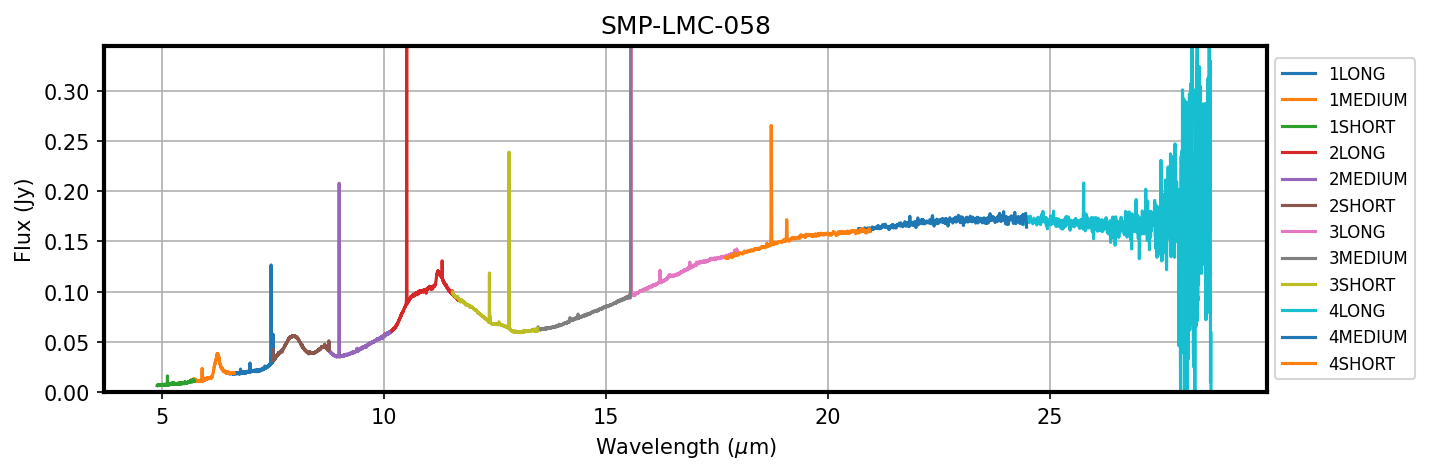

In [36]:
# Normal plots
%matplotlib inline
# Interactive plots
#%matplotlib notebook

rc('axes', linewidth=2)
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)

if (len(x1dfiles) > 0):
    hdu = fits.open(x1dfiles[0])
    objname = hdu[0].header['TARGPROP']
    hdu.close()
else:
    objname = 'Unknown'

ymin,ymax=np.nan,np.nan
for file in x1dfiles:
    x1d = fits.open(file)
    x1ddata = x1d[1].data
    wave = x1ddata['WAVELENGTH']
    flux = x1ddata['FLUX']
    ymin = np.nanmin([ymin, np.nanpercentile(flux,2)])
    ymax = np.nanmax([ymax, np.nanpercentile(flux,99.5)])
    
    # labels
    label = x1d[0].header['CHANNEL'] + x1d[0].header['BAND']
    
    plt.plot(wave, flux, label=label)
    
    x1d.close()
    
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (Jy)')
plt.title(objname)
plt.ylim(ymin, ymax)
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.savefig('mrs_example_plot.png')

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 